In [79]:
from __future__ import print_function

#!pip install numpy==1.19.5
#!pip install tensorflow==2.2.0
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

#from tensorflow import keras
### hack tf-keras to appear as top level keras
#import sys
#sys.modules['keras'] = keras
### end of hack

from keras.layers import Input, Dense, Lambda, Reshape
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist

from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()



print(np.__version__)


1.21.5


In [90]:
# defining the key parameters
batch_size = 100

# Parameters of the input images (handwritten digits)
original_dim = 28*28

# Latent space is of dimension 2.  This means that we are reducing the dimension from 784 to 2
latent_dim = 2
intermediate_dim = 256
epochs = 50
epsilon_std = 1.0

In [91]:
def sampling(args: tuple):
    # we grab the variables from the tuple
    z_mean, z_log_var = args
    print(z_mean)
    print(z_log_var)
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon  # h(z)

In [92]:
# input to our encoder
x = Input(shape=(original_dim,), name="input")
# intermediate layer
h = Dense(intermediate_dim, activation='relu', name="encoding")(x)
# defining the mean of the latent space
z_mean = Dense(latent_dim, name="mean")(h)
# defining the log variance of the latent space
z_log_var = Dense(latent_dim, name="log-variance")(h)
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
# defining the encoder as a keras model
encoder = Model(x, [z_mean, z_log_var, z], name="encoder")
# print out summary of what we just did
encoder.summary()

Tensor("mean_7/BiasAdd:0", shape=(None, 2), dtype=float32)
Tensor("log-variance_7/BiasAdd:0", shape=(None, 2), dtype=float32)
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 784)]        0           []                               
                                                                                                  
 encoding (Dense)               (None, 256)          200960      ['input[0][0]']                  
                                                                                                  
 mean (Dense)                   (None, 2)            514         ['encoding[0][0]']               
                                                                                                  
 log-variance (Dense)           (None, 2)            514         

In [93]:
# Input to the decoder
input_decoder = Input(shape=(latent_dim,), name="decoder_input")
# taking the latent space to intermediate dimension
decoder_h = Dense(intermediate_dim, activation='relu', name="decoder_h")(input_decoder)
# getting the mean from the original dimension
x_decoded = Dense(original_dim, activation='sigmoid', name="flat_decoded")(decoder_h)
# defining the decoder as a keras model
decoder = Model(input_decoder, x_decoded, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 decoder_h (Dense)           (None, 256)               768       
                                                                 
 flat_decoded (Dense)        (None, 784)               201488    
                                                                 
Total params: 202,256
Trainable params: 202,256
Non-trainable params: 0
_________________________________________________________________


In [94]:
# grab the output. Recall, that we need to grab the 3rd element our sampling z
output_combined = decoder(encoder(x)[2])
# link the input and the overall output
vae = Model(x, output_combined)
# print out what the overall model looks like
vae.summary()

Tensor("encoder_6/mean/BiasAdd:0", shape=(None, 2), dtype=float32)
Tensor("encoder_6/log-variance/BiasAdd:0", shape=(None, 2), dtype=float32)
Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 784)]             0         
                                                                 
 encoder (Functional)        [(None, 2),               201988    
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 784)               202256    
                                                                 
Total params: 404,244
Trainable params: 404,244
Non-trainable params: 0
_________________________________________________________________


In [95]:
import tensorflow as tf
from keras.datasets import mnist
from keras import metrics

In [96]:
def vae_loss(x: tf.Tensor, x_decoded_mean: tf.Tensor):
  # Aca se computa la cross entropy entre los "labels" x que son los valores 0/1 de los pixeles, y lo que salió al final del Decoder.
  xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean) # x-^X
  kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
  vae_loss = K.mean(xent_loss + kl_loss)
  return vae_loss

vae.compile( loss=vae_loss)
vae.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 784)]             0         
                                                                 
 encoder (Functional)        [(None, 2),               201988    
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 784)               202256    
                                                                 
Total params: 404,244
Trainable params: 404,244
Non-trainable params: 0
_________________________________________________________________


In [98]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

4422102/4422102 [==============================] - 1s 0us/step


In [99]:
vae.fit(x_train, x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size)

Train on 60000 samples
Epoch 1/50
60000/60000 [==============================] - 20s 327us/sample - loss: 302.4452
Epoch 2/50
60000/60000 [==============================] - 11s 192us/sample - loss: 277.6393
Epoch 3/50
60000/60000 [==============================] - 12s 205us/sample - loss: 273.8158
Epoch 4/50
60000/60000 [==============================] - 14s 229us/sample - loss: 272.0688
Epoch 5/50
60000/60000 [==============================] - 13s 212us/sample - loss: 270.8187
Epoch 6/50
60000/60000 [==============================] - 10s 167us/sample - loss: 269.7814
Epoch 7/50
60000/60000 [==============================] - 9s 145us/sample - loss: 268.9399
Epoch 8/50
60000/60000 [==============================] - 9s 148us/sample - loss: 268.2669
Epoch 9/50
60000/60000 [==============================] - 9s 152us/sample - loss: 267.7067
Epoch 10/50
60000/60000 [==============================] - 10s 164us/sample - loss: 267.2082
Epoch 11/50
60000/60000 [==============================] - 

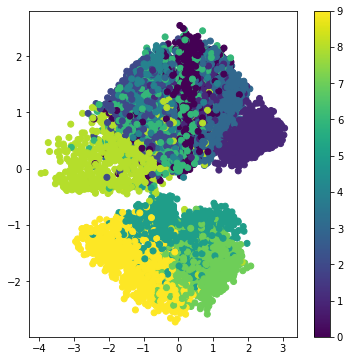

In [100]:
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)[0]
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:,0], x_test_encoded[:,1], c=y_test, cmap='viridis')
plt.colorbar()
plt.show()

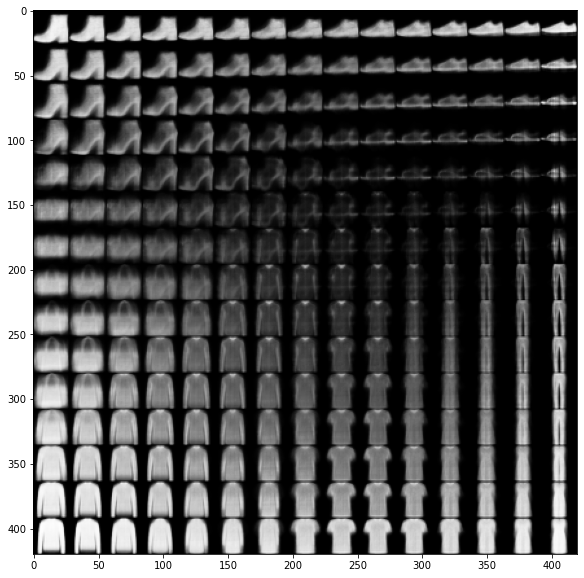

In [101]:
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()